# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math
import os

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def frame_smooth_(frame, history, history_length):
    w_step = 1/(history_length + 1)
    l = len(history)
    i = l
    
    #if l <= n_used:
    wi = (1-l+history_length)*w_step
    #else:
    #    wi = (1-n_used+n)*w_step
        
    w = 0
    s = [0]*len(frame)    
    history.insert(0, frame)

    while i>=0:
        for k in range(0, len(s)):
            s[k] += wi * history[i][k]
        w += wi
        wi += w_step
        i -=1
        
    for k in range(0, len(frame)):
        history[0][k] = s[k] / w
        
    smoothed = history[0]    
        
    if l+1 > history_length:
        history.pop()
        
    return smoothed    

def frame_smooth(frame, history, history_length):
    l = len(history)
    
    if l < history_length:
        history.insert(0, frame)
        return frame
    
    w_step = 1/(history_length + 1)
    
    i = l
    wi = w_step
    w = 0
    s = [0]*len(frame)    
    history.insert(0, frame)

    while i>=0:
        for k in range(0, len(s)):
            s[k] += wi * history[i][k]
        w += wi
        wi += w_step
        i -=1
        
    for k in range(0, len(frame)):
        history[0][k] = s[k] / w
        
    smoothed = history[0]    
        
    if l+1 > history_length:
        history.pop()
        
    return smoothed 


def filter_lines(lines):
    slopes = [pair[0] for pair in lines]
    intercepts = [pair[1] for pair in lines]
    
    if (not slopes) | (not intercepts):
        return []
    
    slopes_Q1 = np.percentile(slopes, 25)
    slopes_Q3 = np.percentile(slopes, 50)
    slopes_IQR = slopes_Q3 - slopes_Q1
    
    intercepts_Q1 = np.percentile(intercepts, 25)
    intercepts_Q3 = np.percentile(intercepts, 50)
    intercepts_IQR = intercepts_Q3 - intercepts_Q1    
    
    lines_kept = []
    for pair in lines:
        if (pair[0] >= slopes_Q1 - 1.5 * slopes_IQR)&(pair[0] <= slopes_Q3 + 1.5 * slopes_IQR)&\
           (pair[1] >= intercepts_Q1 - 1.5 * intercepts_IQR)&(pair[1] <= intercepts_Q3 + 1.5 * intercepts_IQR):
            lines_kept += [pair]
            
    return lines_kept

def draw_avg_line(img, lines, apex_v, color, thickness, history, history_length):
    if lines:  
        a = np.mean([pair[0] for pair in lines])
        b = np.mean([pair[1] for pair in lines])
        frame = frame_smooth([a, b], history, history_length)
        a = frame[0]
        b = frame[1]
        
        y_bottom = img.shape[0]
        y_apex = y_bottom * apex_v          
    
        x1 = int(round((y_bottom - b)/a))
        y1 = y_bottom
        x2 = int(round((y_apex - b)/a))
        y2 = int(round(y_apex))
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)    
        
#For Debugging        
def draw_every_line(img, lines, apex_v, thickness=2):
    y_bottom = img.shape[0]
    y_apex = y_bottom * apex_v 
    
    if lines:
        for pair in lines:
            slope = pair[0]
            intercept = pair[1]
                
            y1 = int(round(y_bottom))
            x1 = int(round( (y1 - intercept)/slope ))
                
            y2 = int(round(y_apex))
            x2 = int(round((y2 - intercept)/slope))
                
            if slope > 0:
                color = [0,250,0]
            else:
                color = [0,0,250]
                        
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)         
                    
        
def draw_lines(img, lines, history, history_length, slope_threshold, apex_v, color=[250, 0, 0], thickness=5):
    left = []
    right = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x1!=x2)&(y1!=y2): # eliminate vertical and horizontal lines
                slope = (y2-y1)/(x2-x1)
                
                if np.abs(slope) > slope_threshold:
                    intercept = y1 - slope*x1

                    if slope < 0:
                        left += [[slope, intercept]]
                    else:
                        right += [[slope, intercept]]
                    
    #left = filter_lines(left)
    #right = filter_lines(right)
    
    #For Debugging only
    #draw_every_line(img, left, apex_v)
    #draw_every_line(img, right, apex_v)    
    
    #Draw left and Right lines 
    draw_avg_line(img, left, apex_v, color, thickness, history['left'], history_length)
    draw_avg_line(img, right, apex_v, color, thickness, history['right'], history_length)
    

def hough_lines(img, history, history_length, rho, theta, threshold, min_line_len, max_line_gap, slope_threshold, apex_v):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, history, history_length, slope_threshold=slope_threshold, apex_v=apex_v)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [4]:
global_frames = []
values = [i for i in range(0,20)]

for v in values:
    r = frame_smooth([v], global_frames, 10)
    print(v, '    ', r, '     ', global_frames)

0      [0]       [[0]]
1      [1]       [[1], [0]]
2      [2]       [[2], [1], [0]]
3      [3]       [[3], [2], [1], [0]]
4      [4]       [[4], [3], [2], [1], [0]]
5      [5]       [[5], [4], [3], [2], [1], [0]]
6      [6]       [[6], [5], [4], [3], [2], [1], [0]]
7      [7]       [[7], [6], [5], [4], [3], [2], [1], [0]]
8      [8]       [[8], [7], [6], [5], [4], [3], [2], [1], [0]]
9      [9]       [[9], [8], [7], [6], [5], [4], [3], [2], [1], [0]]
10      [6.666666666666667]       [[6.666666666666667], [9], [8], [7], [6], [5], [4], [3], [2], [1]]
11      [7.161616161616162]       [[7.161616161616162], [6.666666666666667], [9], [8], [7], [6], [5], [4], [3], [2]]
12      [7.6305479032751755]       [[7.6305479032751755], [7.161616161616162], [6.666666666666667], [9], [8], [7], [6], [5], [4], [3]]
13      [8.077172088191372]       [[8.077172088191372], [7.6305479032751755], [7.161616161616162], [6.666666666666667], [9], [8], [7], [6], [5], [4]]
14      [8.506155272287673]       [[8.5061

In [5]:
def detect_lanes(image, history, parameters):
   
    # Grayscale the image
    gray_image = grayscale(image)

    #Color selection
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)    
    lower_yellow = np.array([20, 100, 100], dtype ='uint8')
    upper_yellow = np.array([30, 255, 255], dtype='uint8')
    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)

    #gray = cv2.bitwise_and(gray_image, mask_yw)
    
    #Debug
    gray = gray_image
    
    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, parameters['kernel_size'])
    
    # Apply Canny 
    edges = canny(blur_gray, low_threshold = parameters['low_threshold'], high_threshold = parameters['high_threshold'])
    
    #Debug
    #return np.dstack((edges,edges,edges))
   
    # Define a four sided polygon to mask
    imshape = edges.shape
    vertices = np.array([[(0,imshape[0]),
                          (imshape[1]/2-imshape[1]*parameters['apex_h']/2, imshape[0]*parameters['apex_v']),
                          (imshape[1]/2+imshape[1]*parameters['apex_h']/2, imshape[0]*parameters['apex_v']),
                          (imshape[1],imshape[0])]], dtype=np.int32)
    
    # Create a masked edges
    masked_edges = region_of_interest(edges, vertices)
    
    #Debug
    #return np.dstack((masked_edges,masked_edges,masked_edges))

    # Define the Hough transform parameters
    rho = parameters['rho'] # distance resolution in pixels of the Hough grid
    theta = parameters['theta'] # angular resolution in radians of the Hough grid
    threshold = parameters['threshold']     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = imshape[0]*parameters['min_line_length_p'] #minimum number of pixels making up a line
    max_line_gap = imshape[0]*parameters['max_line_gap_p'] # maximum gap in pixels between connectable line 
    
    # Define additional parameters
    slope_threshold = parameters['slope_threshold']
    apex_v = parameters['apex_v']
    history_length = parameters['history_length']

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, history, history_length, rho, theta, threshold, min_line_length, max_line_gap, slope_threshold, apex_v)
    
    #Debug
    #image = np.dstack((masked_edges,masked_edges,masked_edges))
    
    # Draw the lines on the edge image
    lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    
    return lines_edges

In [6]:
def run_pipeline(folder, parameters):
    test_images = os.listdir(folder)
    fig = plt.figure(figsize=(17,30)) 
    #plt.suptitle('Input images')

    subplot = 1
    for filename in test_images:
        # Draw input image
        image = mpimg.imread(folder + filename)
        fig.add_subplot(len(test_images),2,subplot).set_title(filename)
        _ = plt.imshow(image)
        
        # Create output image with detected lanes
        lane_image = detect_lanes(image, {'left':[], 'right':[]}, parameters)
        lane_filename = 'lane_' + filename
    
        # Draw output image
        fig.add_subplot(len(test_images),2,subplot + 1).set_title(lane_filename)
        _ = plt.imshow(lane_image)
    
        subplot += 2
        
        # Save output image
        mpimg.imsave('test_images_output/' + lane_filename, lane_image)        

In [7]:
# Pipeline parameters
parameters = {
              'kernel_size': 5,  # Gaussian smoothing parameter
              'low_threshold': 50, # Canny parameter
              'high_threshold': 150, # Canny parameter
              'apex_h': 0.04, # used in mask polygon definition
              'apex_v': 0.6, # used in mask polygon definition
              'rho': 2, # distance resolution in pixels of the Hough grid
              'theta': np.pi / 180, # angular resolution in radians of the Hough grid  
              'threshold': 15,  # minimum number of votes (intersections in Hough grid cell)
              'min_line_length_p': 0.02, # minimum number of pixels making up a line min_line_length = image ysize * min_line_length_p
              'max_line_gap_p': 0.037,  # maximum gap in pixels between connectable line segments max_line_gap = image ysize * max_line_gap_p 
              'slope_threshold': 0, # used to filter out near horizontal lines 
              'history_length': 10 # number of previous frames to take into account while smoothing (for video only)
             }

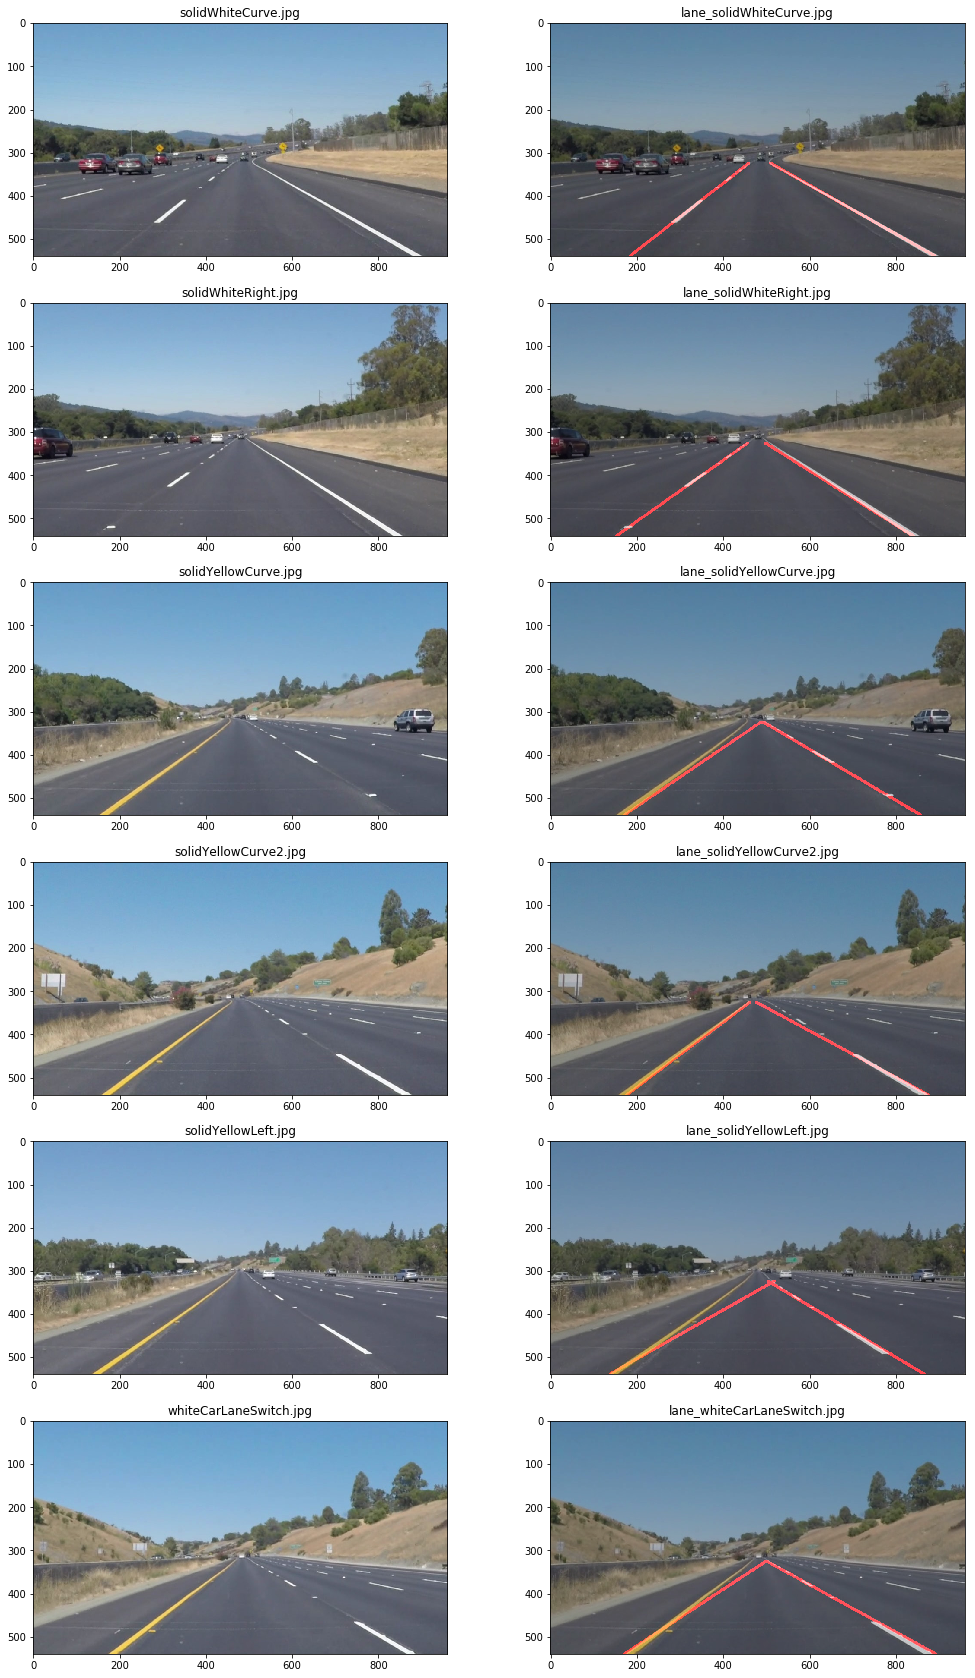

In [8]:
run_pipeline("test_images/", parameters)

## Test on Videos

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
global_history = {'left':[], 'right':[]}
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = detect_lanes(image, global_history, parameters)

    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
global_history = {'left':[], 'right':[]} # Clean up history
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:08<00:00, 24.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 10.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
global_history = {'left':[], 'right':[]}
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:30<00:00, 22.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 32.6 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Problems identified:
* Existance of non lane lines caused by shadows and car's front edge 
* Lane line almost dissapear under sunlight
* Some segments are curved    

Get images with identified problems for testing purposes (run once):

In [23]:
# Pipeline parameters for challenge
parameters = {
              'kernel_size': 5,  # Gaussian smoothing parameter
              'low_threshold': 50, # Canny parameter
              'high_threshold': 150, # Canny parameter
              'apex_h': 0.04, # used in mask polygon definition
              'apex_v': 0.59, # used in mask polygon definition
              'rho': 2, # distance resolution in pixels of the Hough grid
              'theta': np.pi / 180, # angular resolution in radians of the Hough grid  
              'threshold': 15,  # minimum number of votes (intersections in Hough grid cell)
              'min_line_length_p': 0.02, # minimum number of pixels making up a line min_line_length = image ysize * min_line_length_p
              'max_line_gap_p': 0.037,  # maximum gap in pixels between connectable line segments max_line_gap = image ysize * max_line_gap_p 
              'slope_threshold': 0.0,
              'history_length': 0
             }

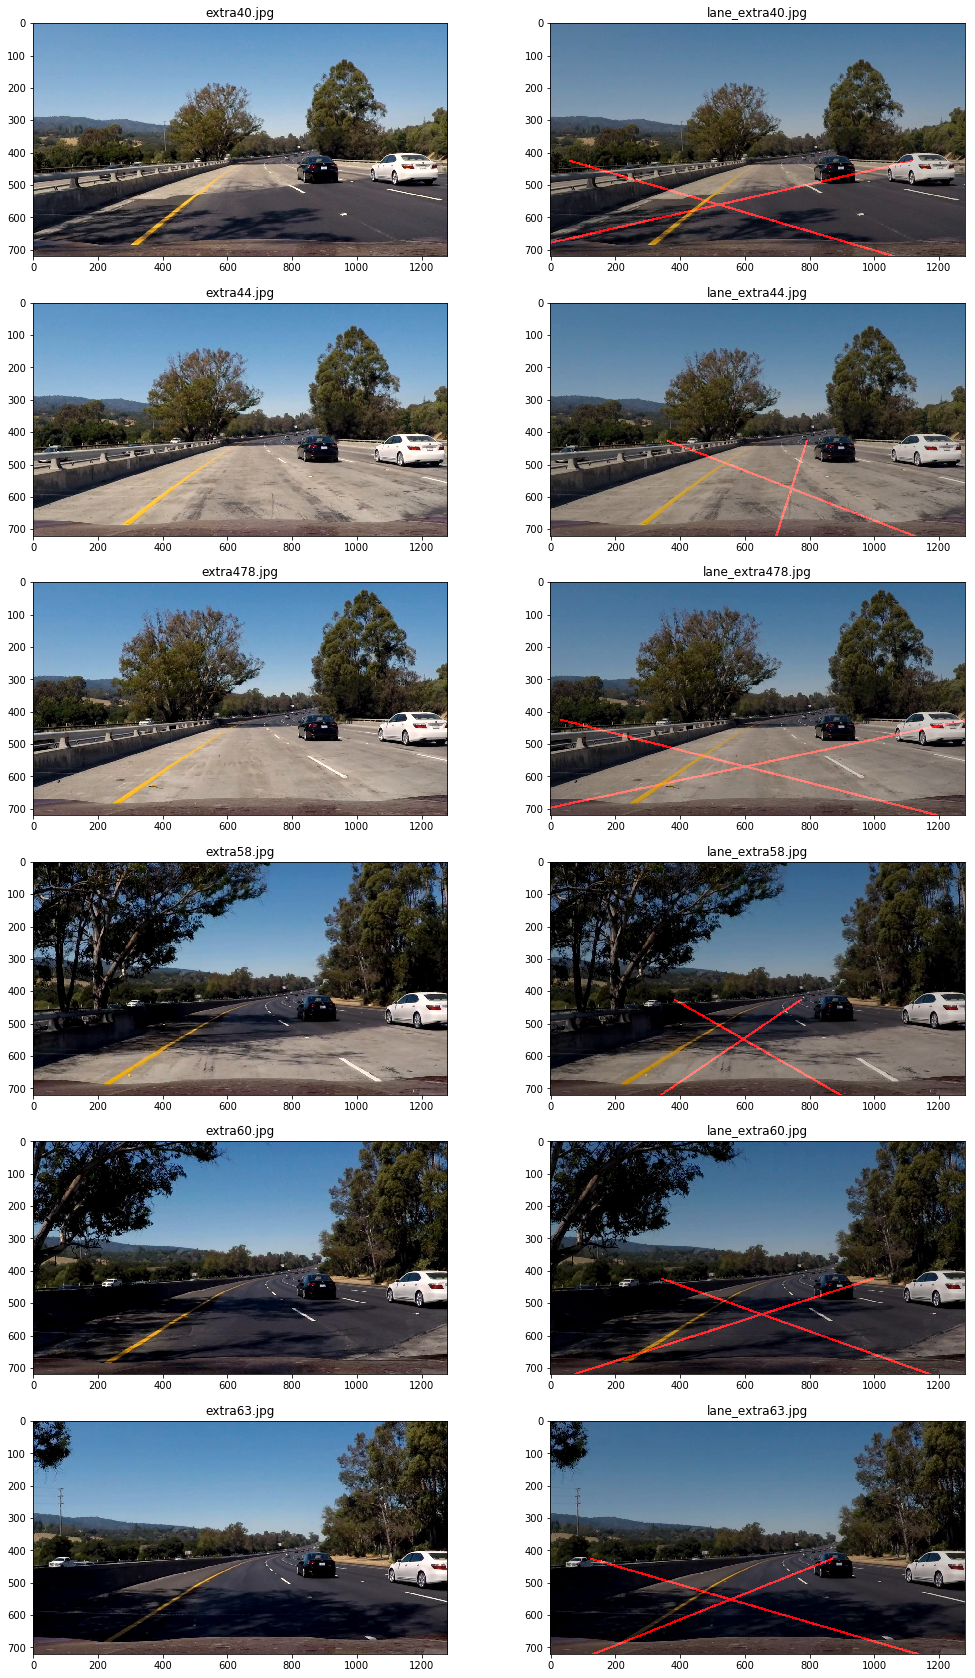

In [24]:
run_pipeline("challenge_images/", parameters)

In [25]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
global_history = {'left':[], 'right':[]}
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:28<00:00,  8.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 32.8 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))